In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import pandas as pd
from pyensembl import EnsemblRelease  # pyensembl install --release 77 --species homo_sapiens
from tqdm import tqdm

from functions import *

# Sanitize grQTLs

In [3]:
# Get grqtls
grqtls = get_grqtls()
def split_region(s):
    match = re.search('^chr(.+):(\d+)(?:)(?:_._.)?$', s)
    return {'Chromosome': str(match.group(1)), 'SNP Start': int(match.group(2))}
def split_id(s):
    match = re.search('^(.+) --> (.+)_to_(.+)$', s)
    region = split_region(match.group(1))
    tf, tg = match.group(2), match.group(3)
    return {**region, 'TF': tf, 'TG': tg}
for col in split_id(grqtls['id'].iloc[0]):
    grqtls[col] = grqtls['id'].apply(lambda s: split_id(s)[col])
grqtls = grqtls.rename(columns={'celltype': 'Cell Type'})
grqtls = grqtls[['Chromosome', 'SNP Start', 'TF', 'TG', 'Kind', 'Cell Type']].reset_index(drop=True)

In [4]:
# Get TF and TG locations
ensembl = EnsemblRelease(77)
unknown_genes = []
for kind in ('TF', 'TG'):
    opposite_kind = 'TG' if kind=='TF' else 'TF'
    mask = grqtls['Kind']==f'cis{kind}'
    def get_loci(gene_name):
        try: return ensembl.loci_of_gene_names(gene_name)[0]
        except: unknown_genes.append(gene_name); return None
    # Same
    loci = list(map(get_loci, grqtls.loc[mask, kind]))
    grqtls.loc[mask, 'Gene Chromosome'] = list(map(lambda l: l.contig if l is not None else l, loci))
    equal_or_na = (grqtls.loc[mask, 'Chromosome'] == grqtls.loc[mask, 'Gene Chromosome']) + grqtls.loc[mask, 'Gene Chromosome'].isna()
    assert equal_or_na.sum() == mask.sum()
    grqtls.loc[mask, 'Gene Start'] = list(map(lambda l: int(l.start) if l is not None else l, loci))
    # Opposite
    loci = list(map(get_loci, grqtls.loc[mask, opposite_kind]))
    grqtls.loc[mask, 'Opposite Gene Chromosome'] = list(map(lambda l: l.contig if l is not None else l, loci))
    grqtls.loc[mask, 'Opposite Gene Start'] = list(map(lambda l: int(l.start) if l is not None else l, loci))
print(f'{np.unique(unknown_genes).shape[0]} unrecognized genes found: {", ".join(np.unique(unknown_genes))}')

25 unrecognized genes found: ADD3-AS1, ADGRD1, ADGRE2, ADGRE4P, ADGRF5, ADGRG1, ADGRG5, ADGRG6, ADGRL2, ADGRL4, ADGRV1, ANOS1, ARRDC3-AS1, CARMN, FCGR1CP, GPAT3, LINC01619, MIR34AHG, NECTIN2, PLPP3, PLPPR1, SAMD12-AS1, SUSD6, TMIGD3, TNS2


# Sanitize MPRA QTLs

In [5]:
# Read significant MPRA qtls
mpra = pd.read_csv('../../data/mpra_table2.csv')
# Separate locations
for col in split_region(mpra['chr:pos_A0_A1'].iloc[0]):
    mpra[col] = mpra['chr:pos_A0_A1'].apply(lambda s: split_region(s)[col])
# Filter
mpra = mpra.loc[mpra['Disorder']=='AD']
mpra = mpra.loc[mpra['CRISPR q-value']!='–']
# mpra = mpra[['Chromosome', 'SNP Start']]


In [6]:
# Compute significance
# def q_to_min_num(s):
#     entries = s.split('; ')
#     # Special cases
#     entries = ['1' if e=='–' else e for e in entries]
#     entries = [e[1:] if str(e).startswith('<') else e for e in entries]
#     # Main aggregation
#     entries = [e.split(' × ') for e in entries]  # Separate scientific notation
#     entries = [[e[0], e[1].split('−')] if len(e)==2 else e for e in entries]  # Separate powers
#     entries = [[e[0], float(e[1][0])**-float(e[1][1])] if len(e)==2 else e for e in entries]  # Compute powers
#     entries = [[float(e[0])*e[1]] if len(e)==2 else e for e in entries]  # Aggregate scientific
#     entries = [float(e[0]) for e in entries]  # Convert all
#     return min(entries)
# mpra['Significance'] = mpra['CRISPR q-value'].apply(q_to_min_num)

In [7]:
# Fake MPRA data
# mpra = mpra.rename(columns={'Chr', 'Chromosome'})
# mpra = mpra.loc[mpra['frVars']>0]

# mpra = [
#     'chr11:16246208',
#     'chr16:79493142',
# ]
# mpra = pd.DataFrame({'_origin': mpra})
# for col in ('Chromosome', 'SNP Start'):
#     mpra[col] = mpra['_origin'].apply(lambda s: split_region(s)[col])
# mpra = mpra.drop(columns='_origin')

# Find Overlaps

Found 390: 100%|████████████████████████████████████████████████████| 33288/33288 [00:24<00:00, 1367.95it/s]


Chromosomes:  1, 11, 14, 16, 19, 2, 6, 8
Loci:  APOE;APOE, BIN1, CELF1/SPI1, CLU, CR1, HLA-DRB1/5, IQCK;IQCK, MS4A, MS4A;MS4A, SLC24A4/RIN3
Cell Types:  smc(24), astro(21), micro(18), vlmc(18), pc(17), pvm(16), oligo(16), opc(15), in_pvalb_chc(15), en_l3_5_it_3(14), en_l2_3_it(14), in_pvalb(13), en_l6_ct(13), en_l6_it_1(13), en_l3_5_it_2(12), in_adarb2(12), immune(12), in_vip(11), en_l5_6_np(9), in_lamp5_lhx6(9), in_sst(9), en_l5_et(9), endo(8), en_l6_it_2(8), en_l3_5_it_1(8), in_lamp5_reln(8), en_l6b(6)


<Axes: >

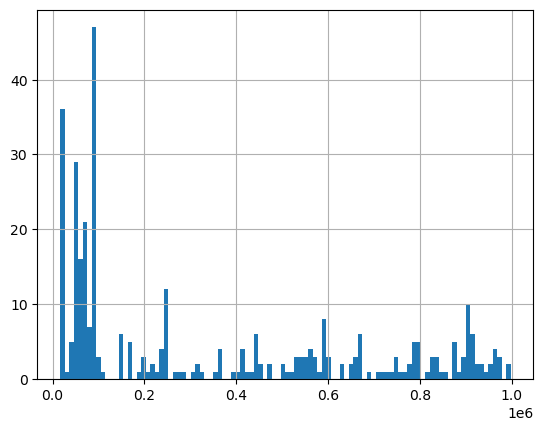

In [11]:
# Parameters
search_distance = int(1e6)
target_cols = [
    # #Overlaps #MPRA/14 SEARCHDIST
    # 33        1MPRA    2e4
    # 163       2MPRA    1e5
    # 390       10MPRA   1e6
    ('Chromosome', 'SNP Start'),  
    ('Gene Chromosome', 'Gene Start'),  # 188
    ('Opposite Gene Chromosome', 'Opposite Gene Start'),  # 25
][0]
chromosome_col, start_col = target_cols

# Annotate SNP distance
grqtls['Closest'] = None
grqtls['Distances'] = None
grqtls['Loci'] = None
grqtls['Overlaps'] = None
for i, r in (pbar := tqdm(grqtls.iterrows(), total=grqtls.shape[0], desc='Found 0')):
    # Filter for missing data
    if np.array([r[col] is None for col in target_cols]).any(): continue

    # Filter by chromosome
    mask = mpra['Chromosome'] == r[chromosome_col]
    if mask.sum()==0: continue

    # Filter by distance
    dist = (mpra.loc[mask, 'SNP Start'] - r[start_col]).astype(int)
    # if mask.sum() > 1: print(dist.abs().min())
    mask[mask] = dist.abs() <= search_distance
    if mask.sum()==0: continue

    # Record
    grqtls.loc[i, 'Closest'] = dist.abs().min()
    grqtls.loc[i, 'Distances'] = '; '.join(map(str, np.sort(dist.abs())[:mask.sum()]))
    grqtls.loc[i, 'Loci'] = '; '.join(mpra.loc[mask, 'Locus'])
    grqtls.loc[i, 'Overlaps'] = mask.sum()
    pbar.set_description(f'Found {grqtls["Overlaps"].sum()}')
overlapping_grqtls = grqtls.loc[grqtls['Overlaps']>0]
# grqtls.loc[grqtls['Overlaps']>0, 'Loci'].unique()
print(f'Chromosomes:  {", ".join(np.unique(overlapping_grqtls["Chromosome"]))}')
print(f'Loci:  {", ".join([l.replace("; ", ";") for l in np.unique(overlapping_grqtls["Loci"])])}')
ct_counts = overlapping_grqtls.groupby('Cell Type')['Chromosome'].count().sort_values(ascending=False)
print(f'Cell Types:  {", ".join([f"{ct_counts.index[i]}({ct_counts.iloc[i]})" for i in range(ct_counts.shape[0])])}')
overlapping_grqtls['Closest'].hist(bins=100)